In [18]:
import os
import math
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization, LeakyReLU, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
tf.random.set_seed(42)

In [2]:
class DataProcessor:
    def __init__(self, base_path):
        self.base_path = base_path
        self.image_size = (360, 360)
        self.label_encoder = None
    
    def apply_augmentation(self, image, bbox):
        bbox = tf.cast(bbox, tf.float32)
        
        h, w = float(self.image_size[0]), float(self.image_size[1])
        bbox_pixel = bbox * tf.constant([w, h, w, h], dtype=tf.float32)
        
        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_left_right(image)
            bbox_pixel = tf.stack([
                w - bbox_pixel[2],
                bbox_pixel[1],    
                w - bbox_pixel[0], 
                bbox_pixel[3]      
            ])
        
        if tf.random.uniform([]) > 0.5:
            angle = tf.random.uniform([], minval=-15, maxval=15) * math.pi / 180
            image = tf.keras.layers.RandomRotation(
                factor=(-15/360, 15/360),
                fill_mode='constant',
                fill_value=1.0
            )(image)
            
            center_x = (bbox_pixel[0] + bbox_pixel[2]) / 2
            center_y = (bbox_pixel[1] + bbox_pixel[3]) / 2
            width = bbox_pixel[2] - bbox_pixel[0]
            height = bbox_pixel[3] - bbox_pixel[1]
            
            cos_theta = tf.cos(angle)
            sin_theta = tf.sin(angle)
            new_center_x = (center_x - w/2) * cos_theta - (center_y - h/2) * sin_theta + w/2
            new_center_y = (center_x - w/2) * sin_theta + (center_y - h/2) * cos_theta + h/2
            
            expansion_factor = 1.2
            new_width = width * expansion_factor
            new_height = height * expansion_factor
            
            bbox_pixel = tf.stack([
                tf.clip_by_value(new_center_x - new_width/2, 0, w),
                tf.clip_by_value(new_center_y - new_height/2, 0, h),
                tf.clip_by_value(new_center_x + new_width/2, 0, w),
                tf.clip_by_value(new_center_y + new_height/2, 0, h)
            ])
        
        if tf.random.uniform([]) > 0.5:
            zoom_factor = tf.random.uniform([], minval=0.9, maxval=1.0)
            image = tf.image.central_crop(image, zoom_factor)
            image = tf.image.resize(image, self.image_size)
            
            bbox_pixel = bbox_pixel * zoom_factor
            bbox_pixel = tf.clip_by_value(bbox_pixel, 0, tf.maximum(w, h))
        
        if tf.random.uniform([]) > 0.5:
            image = tf.image.random_brightness(image, 0.2)
            image = tf.image.random_contrast(image, 0.8, 1.2)
            image = tf.image.random_saturation(image, 0.8, 1.2)
            image = tf.image.random_hue(image, 0.1)
        
        if tf.random.uniform([]) > 0.5:
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.01)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)
        
        bbox = bbox_pixel / tf.constant([w, h, w, h], dtype=tf.float32)
        return image, bbox

    def load_and_preprocess_image(self, filename, label, bbox):
        try:
            img = tf.io.read_file(filename)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, self.image_size)
            img = tf.cast(img, tf.float32) / 255.0
            
            img, bbox = self.apply_augmentation(img, bbox)
            
            return img, label, bbox
        except tf.errors.NotFoundError:
            tf.print(f"File not found: {filename}")
            return None, None, None
            
    def create_dataset(self, csv_file, base_dir, is_training=True, batch_size=32):
        df = pd.read_csv(csv_file)
        
        if self.label_encoder is None:
            self.label_encoder = LabelEncoder()
            df['class'] = self.label_encoder.fit_transform(df['class'])
        else:
            df['class'] = self.label_encoder.transform(df['class'])
            
        filenames = df['filename'].apply(lambda x: os.path.join(base_dir, x)).values
        labels = df['class'].values
        labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=len(self.label_encoder.classes_))
        
        bboxes = df[['xmin', 'ymin', 'xmax', 'ymax']].values.astype(np.float32)
        
        bboxes = bboxes / np.array([self.image_size[1], self.image_size[0], 
                                   self.image_size[1], self.image_size[0]], 
                                   dtype=np.float32)
        
        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels_one_hot, bboxes))
        dataset = dataset.map(
            lambda f, l, b: (self.load_and_preprocess_image(f, l, b)),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.filter(lambda x, y, z: x is not None)
        
        def prepare_data(img, label, bbox):
            return img, {'class_output': label, 'bbox_output': bbox}
        
        dataset = dataset.map(prepare_data)
        
        if is_training:
            dataset = dataset.shuffle(buffer_size=1000)
        
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        
        return dataset


In [3]:

class VisionModel:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.model = self._build_model()
        
    def _build_model(self):
        inputs = Input(shape=(360, 360, 3))
        
        base_model = base_model = VGG16(weights='imagenet', include_top=False, input_shape=(360, 360, 3))
        for layer in base_model.layers[:-4]:  # Freeze all layers except the last 4
            layer.trainable = False

        for layer in base_model.layers:
            if isinstance(layer, Conv2D):
                layer.kernel_initializer = tf.keras.initializers.HeNormal()
        
        x = base_model(inputs, training=True)
        
        def conv_block(x, filters):
            x = Conv2D(filters, (3, 3), padding='same', 
                        kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.1)(x)
            
            x = Conv2D(filters, (3, 3), padding='same',
                      kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.1)(x)
            
            x = Conv2D(filters, (3, 3), padding='same',
                      kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.1)(x)
            
            x = MaxPooling2D(pool_size=(2, 2))(x)
            return x
            
        x = conv_block(x, 256)
        x = conv_block(x, 384)
        x = conv_block(x, 512)
        
        x = GlobalAveragePooling2D()(x)
        
        def fc_block(x, units, dropout_rate=0.5):
            skip = x
            x = Dense(units)(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.1)(x)
            x = Dropout(dropout_rate)(x)
            if skip.shape[-1] == units:
                x = x + skip
            return x
            
        x = fc_block(x, 512)
        x = fc_block(x, 256)
        x = fc_block(x, 128)
        #x = fc_block(x, 64)
        
        class_output = Dense(self.num_classes, activation='softmax', name='class_output')(x)
        bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(x)  
        
        model = Model(inputs=inputs, outputs=[class_output, bbox_output])
        return model
        
    def compile_model(self, learning_rate=0.0001):
        optimizer = AdamW(
            learning_rate=learning_rate,
            weight_decay=0.0001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        )
        
        self.model.compile(
            optimizer=optimizer,
            loss={
                'class_output': 'categorical_crossentropy',
                'bbox_output': 'huber' 
            },
            loss_weights={'class_output': 1.0, 'bbox_output': 1.0},
            metrics={
                'class_output': ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)],
                'bbox_output': ['mae', tf.keras.metrics.MeanSquaredError()]
            }
        )
    
    def get_callbacks(self, model_dir='model'):
        callbacks = [
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            ModelCheckpoint(
                os.path.join(model_dir, 'model-{epoch:02d}-{val_loss:.2f}.keras'),
                monitor='val_loss',
                save_best_only=True,
                verbose=1,
                save_weights_only=False
            )
        ]
        return callbacks


In [4]:
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()


In [5]:

def train_model():
    base_path = 'dataset/'
    data_processor = DataProcessor(base_path)
    
    train_dataset = data_processor.create_dataset(
        os.path.join(base_path, 'train', '_annotations.csv'),
        os.path.join(base_path, 'train'),
        is_training=True
    )
    
    valid_dataset = data_processor.create_dataset(
        os.path.join(base_path, 'valid', '_annotations.csv'),
        os.path.join(base_path, 'valid'),
        is_training=False
    )
    
    model = VisionModel(num_classes=len(data_processor.label_encoder.classes_))
    model.compile_model()
    
    history = model.model.fit(
        train_dataset,
        epochs=100,
        validation_data=valid_dataset,
        callbacks=model.get_callbacks(),
        workers=4,
        use_multiprocessing=True
    )
    
    model_save_path = 'model/my_model.h5'
    model.model.save(model_save_path)
    print(f'Model saved to: {model_save_path}')
    plot_metrics(history)
    return model, history, data_processor


Epoch 1/100
    183/Unknown - 1534s 8s/step - loss: 0.6680 - class_output_loss: 0.6049 - bbox_output_loss: 0.0631 - class_output_accuracy: 0.7390 - class_output_top_k_categorical_accuracy: 1.0000 - bbox_output_mae: 0.2855 - bbox_output_mean_squared_error: 0.1261
Epoch 1: val_loss improved from inf to 1.16825, saving model to model\model-01-1.17.keras
183/183 [==============================] - 1882s 10s/step - loss: 0.6680 - class_output_loss: 0.6049 - bbox_output_loss: 0.0631 - class_output_accuracy: 0.7390 - class_output_top_k_categorical_accuracy: 1.0000 - bbox_output_mae: 0.2855 - bbox_output_mean_squared_error: 0.1261 - val_loss: 1.1682 - val_class_output_loss: 1.1021 - val_bbox_output_loss: 0.0661 - val_class_output_accuracy: 0.7566 - val_class_output_top_k_categorical_accuracy: 1.0000 - val_bbox_output_mae: 0.3122 - val_bbox_output_mean_squared_error: 0.1322 - lr: 1.0000e-04
Epoch 2/100
183/183 [==============================] - ETA: 0s - loss: 0.3343 - class_output_loss: 0.2921 

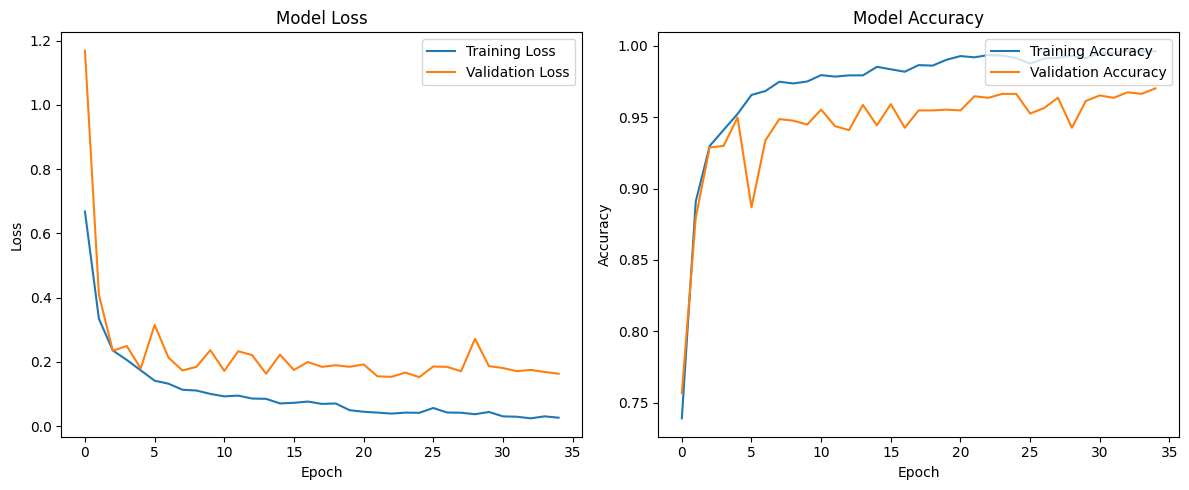

In [6]:
model, history, data_processor = train_model()

28/28 [==============================] - 170s 6s/step
Classification Report:
              precision    recall  f1-score   support

         gun       0.90      0.96      0.93       225
       knife       0.98      0.97      0.97       663

    accuracy                           0.96       888
   macro avg       0.94      0.96      0.95       888
weighted avg       0.96      0.96      0.96       888



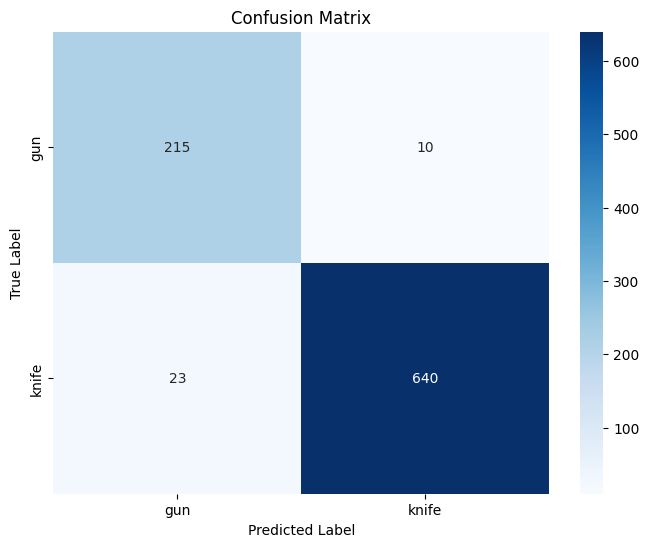

In [7]:

test_dataset = data_processor.create_dataset(
        os.path.join('dataset', 'test', '_annotations.csv'),
        os.path.join('dataset', 'test'),
        is_training=False
    )

    # Predictions on test data
class_pred, bbox_pred = model.model.predict(test_dataset)
class_pred_labels = np.argmax(class_pred, axis=1)

    # Extract true class labels from test dataset
true_class_labels = []
for images, labels in test_dataset.unbatch():
    true_class_labels.append(np.argmax(labels['class_output']))

true_class_labels = np.array(true_class_labels)

    # Classification report
print("Classification Report:")
print(classification_report(true_class_labels, class_pred_labels, target_names=data_processor.label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(true_class_labels, class_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data_processor.label_encoder.classes_, yticklabels=data_processor.label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [8]:
# Evaluate the model

results = model.model.evaluate(test_dataset)

# Unpack the results
test_loss, class_output_loss, bbox_output_loss, test_accuracy, top_k_categorical_accuracy, bbox_output_mae, bbox_output_mean_squared_error = results

# Print the relevant metrics
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')
print(f'Bounding Box MAE: {bbox_output_mae}, Bounding Box MSE: {bbox_output_mean_squared_error}')
print(f'Top-k Categorical Accuracy: {top_k_categorical_accuracy}')


28/28 [==============================] - 169s 6s/step - loss: 0.1801 - class_output_loss: 0.1678 - bbox_output_loss: 0.0123 - class_output_accuracy: 0.9595 - class_output_top_k_categorical_accuracy: 1.0000 - bbox_output_mae: 0.1170 - bbox_output_mean_squared_error: 0.0247
Test Accuracy: 0.9594594836235046, Test Loss: 0.18012520670890808
Bounding Box MAE: 0.11704802513122559, Bounding Box MSE: 0.024662790820002556
Top-k Categorical Accuracy: 1.0


In [10]:
from tensorflow.keras.models import load_model
model = load_model('model/model-25-0.15.keras')

In [11]:
base_path = 'dataset/'
data_processor = DataProcessor(base_path)
test_dataset = data_processor.create_dataset(
    os.path.join(base_path, 'test', '_annotations.csv'),
    os.path.join(base_path, 'test'),
    is_training=False
)

y_pred = model.predict(test_dataset)
print(y_pred)

28/28 [==============================] - 226s 8s/step
[array([[9.9921334e-01, 7.8661134e-04],
       [1.4480976e-04, 9.9985516e-01],
       [4.9468479e-05, 9.9995053e-01],
       ...,
       [9.9746919e-01, 2.5308128e-03],
       [4.8948941e-06, 9.9999511e-01],
       [9.9954236e-01, 4.5770040e-04]], dtype=float32), array([[0.01950732, 0.02498968, 0.96624076, 0.95519125],
       [0.4934406 , 0.6176825 , 0.44199315, 0.663053  ],
       [0.07711059, 0.06071172, 0.9051202 , 0.8499717 ],
       ...,
       [0.04549385, 0.04531816, 0.92958796, 0.92281127],
       [0.40619257, 0.51275676, 0.49275398, 0.74460626],
       [0.00887514, 0.01116866, 0.9838022 , 0.98068523]], dtype=float32)]


In [12]:
# Load test dataset CSV file and encode true labels
test_csv_path = os.path.join(base_path, 'test', '_annotations.csv')
df_test = pd.read_csv(test_csv_path)

# Encode class labels using the same LabelEncoder
if data_processor.label_encoder is None:
    data_processor.label_encoder = LabelEncoder()
    data_processor.label_encoder.fit(df_test['class'])

# Convert class labels to integers for true labels
true_labels = data_processor.label_encoder.transform(df_test['class'])

class_predictions, bbox_predictions = y_pred  # Extract class and bbox predictions

# Convert predicted probabilities to class labels
predicted_classes = class_predictions.argmax(axis=1)

# Classification report for precision, recall, and F1-score
print(classification_report(true_labels, predicted_classes, target_names=data_processor.label_encoder.classes_))


              precision    recall  f1-score   support

         gun       0.92      0.96      0.94       225
       knife       0.99      0.97      0.98       663

    accuracy                           0.97       888
   macro avg       0.95      0.96      0.96       888
weighted avg       0.97      0.97      0.97       888



1/1 [==============================] - 1s 970ms/step
Predicted boxes shape: (4,)
True boxes shape: (4,)
Image shape: (360, 360, 3)
1/1 [==============================] - 1s 703ms/step


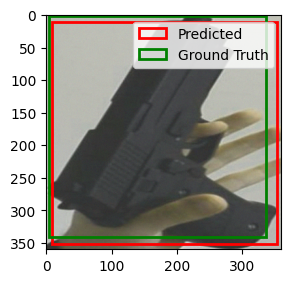

1/1 [==============================] - 0s 308ms/step


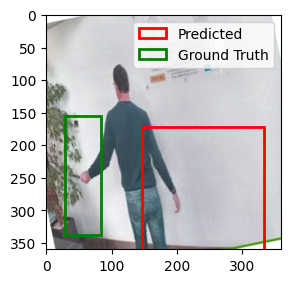

1/1 [==============================] - 0s 347ms/step


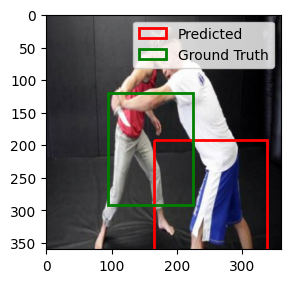

1/1 [==============================] - 0s 362ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05655074..1.009965].


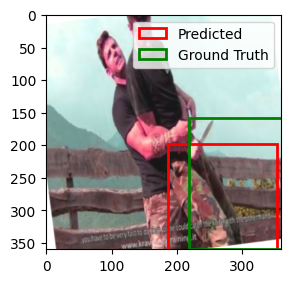

1/1 [==============================] - 0s 297ms/step


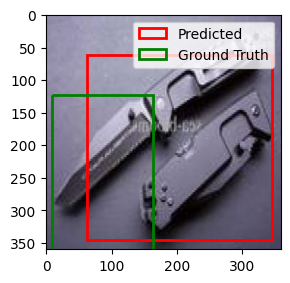

In [13]:
def plot_image_with_boxes(image, pred_boxes, true_boxes=None):
    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='gray')
    
    # Get image dimensions
    height, width = image.shape[:2]

    # Draw predicted box

    if pred_boxes is not None:
        # Extract the box from the nested array and denormalize coordinates
        box = pred_boxes[0]  # Get the first (and only) box
        x = box[0] * width
        y = box[1] * height
        w = box[2] * width
        h = box[3] * height
        
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, 
                                        fill=False, 
                                        color='red', 
                                        linewidth=2,
                                        label='Predicted'))
    
    # Draw ground truth box
    if true_boxes is not None:
        # Extract the box from the nested array and denormalize coordinates
        box = true_boxes[0]  # Get the first (and only) box
        x = box[0] * width
        y = box[1] * height
        w = box[2] * width
        h = box[3] * height
        
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, 
                                        fill=False, 
                                        color='green', 
                                        linewidth=2,
                                        label='Ground Truth'))
    
    plt.legend()
    plt.axis('on')
    plt.tight_layout()
    plt.show()

test_dataset_iter = iter(test_dataset)  
batch = next(test_dataset_iter)  

image = batch[0][0].numpy()  
true_boxes = batch[1]['bbox_output'][0].numpy()  

pred_boxes = model.predict(image[np.newaxis, ...])[1][0]  
print("Predicted boxes shape:", pred_boxes.shape)
print("True boxes shape:", true_boxes.shape)
print("Image shape:", image.shape)

num_images = 5 
for i, batch in enumerate(test_dataset.take(num_images)):
    
    image = batch[0][0].numpy()
    true_boxes = batch[1]['bbox_output'][0].numpy()
    
    pred_boxes = model.predict(image[np.newaxis, ...])[1][0]
    
    plot_image_with_boxes(image, [pred_boxes], [true_boxes])
    
    if i >= num_images - 1:
        break  

# single object plot bbox

1/1 [==============================] - 0s 287ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07939786..1.1105655].


1/1 [==============================] - 0s 323ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10376184..0.898897].


1/1 [==============================] - 0s 285ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030627519..1.1552393].


1/1 [==============================] - 0s 262ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0690343].


1/1 [==============================] - 0s 293ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.122583896..1.0263895].


1/1 [==============================] - 0s 258ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06628649..1.2526286].


1/1 [==============================] - 0s 279ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08962137..1.221165].


1/1 [==============================] - 0s 259ms/step


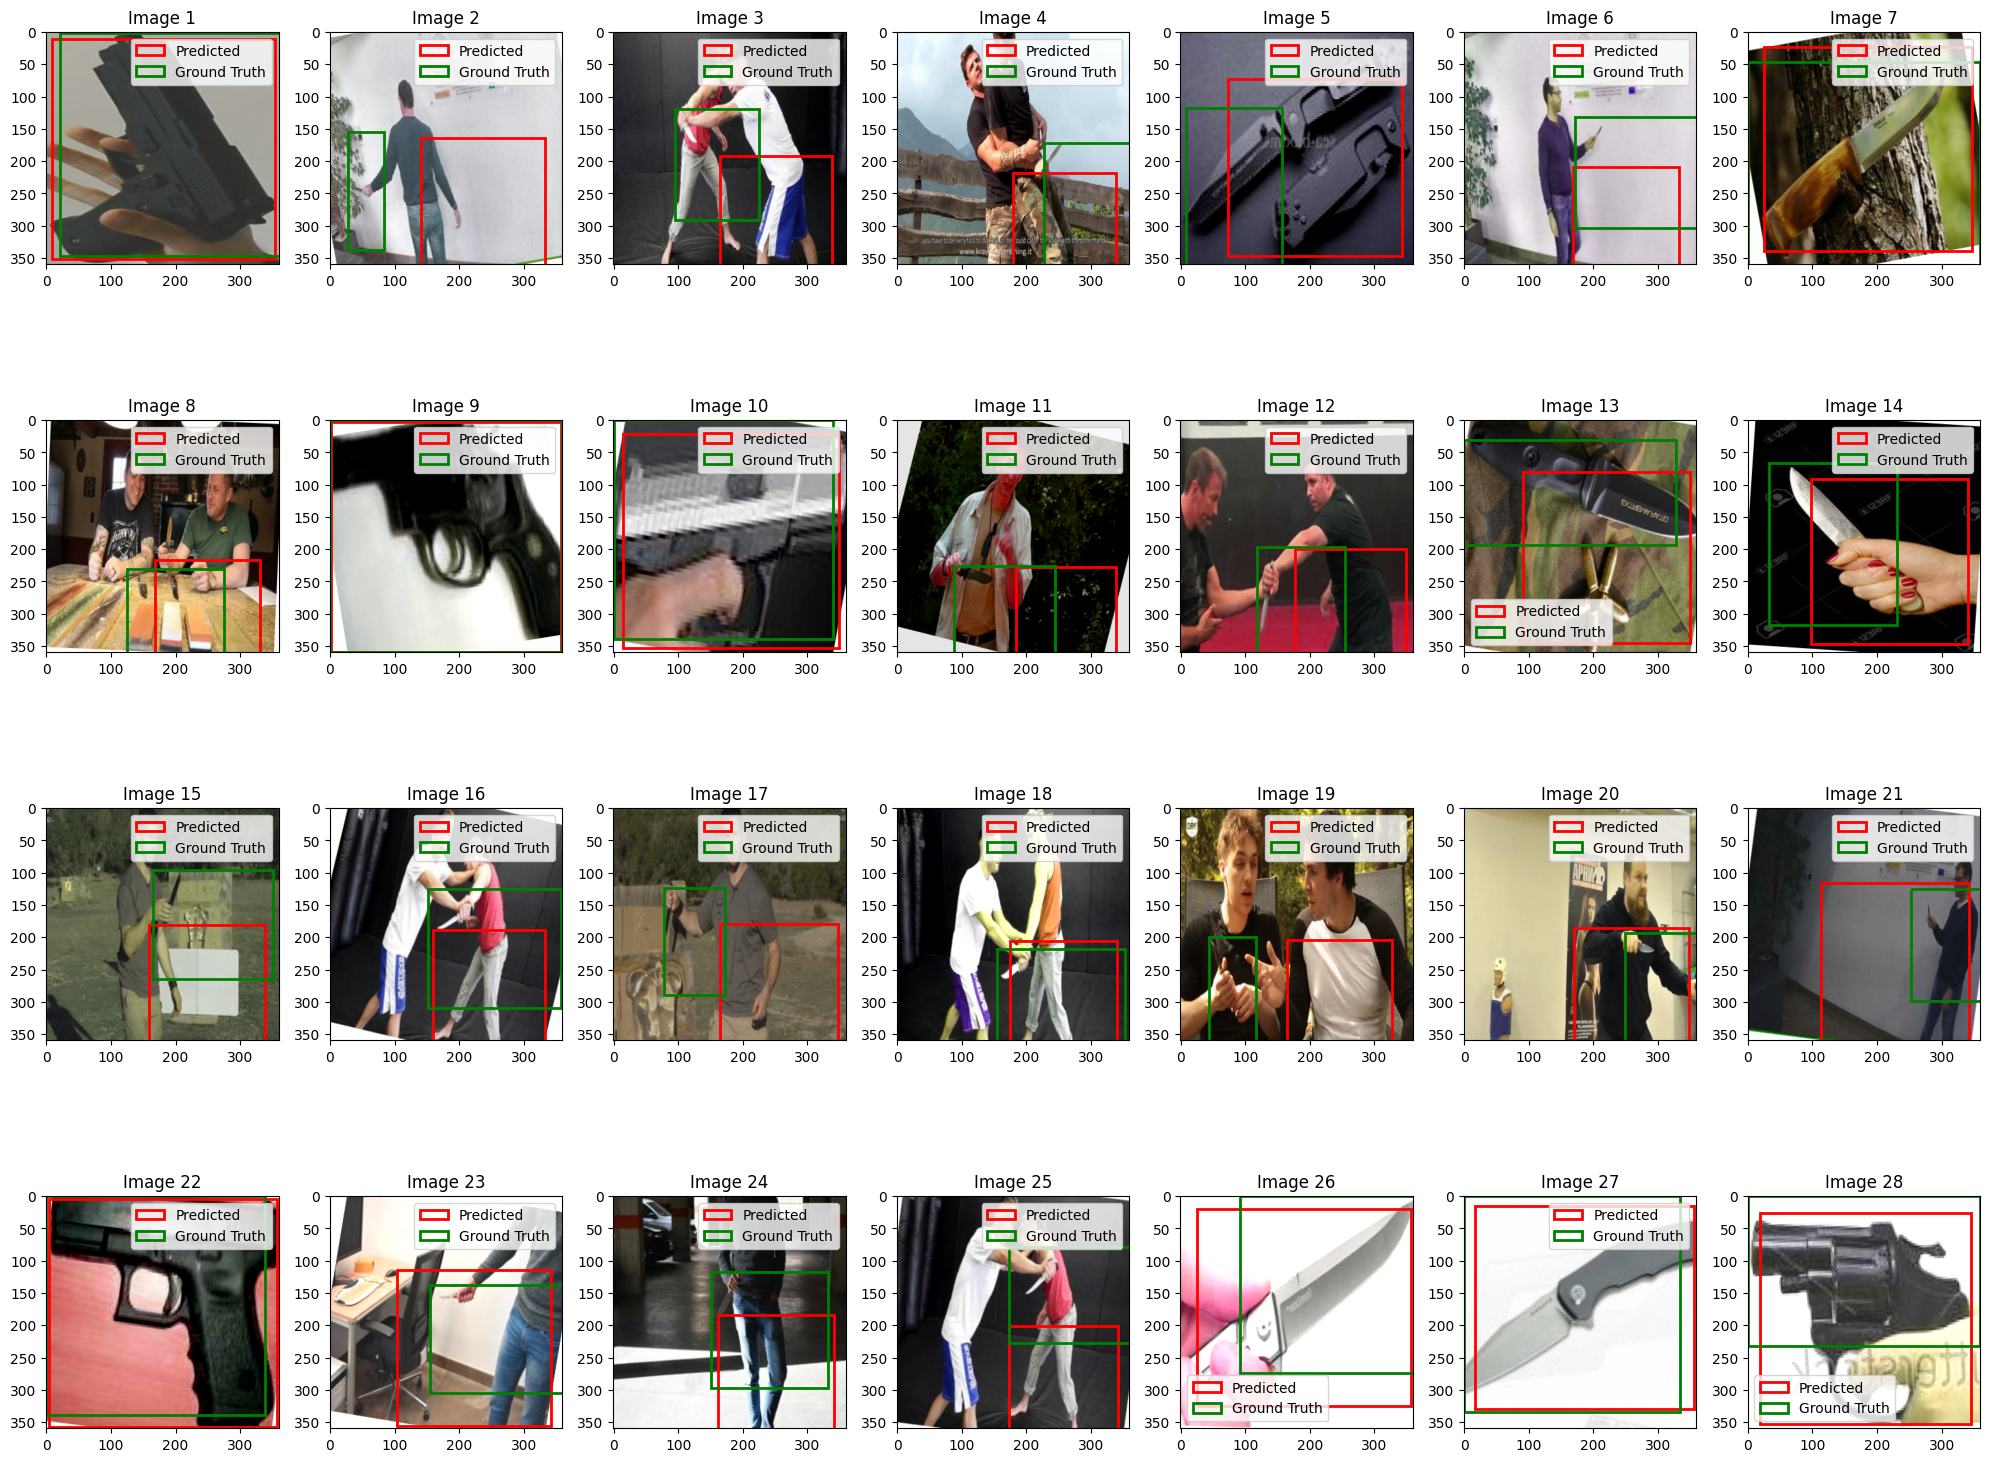

In [14]:
def plot_image_with_boxes(image, pred_boxes, true_boxes=None, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.imshow(image, cmap='gray')
    
    height, width = image.shape[:2]
    
    if pred_boxes is not None:
        box = pred_boxes[0]
        x = box[0] * width
        y = box[1] * height
        w = box[2] * width
        h = box[3] * height
        
        ax.add_patch(plt.Rectangle((x, y), w, h, 
                                 fill=False, 
                                 color='red', 
                                 linewidth=2,
                                 label='Predicted'))
    
    if true_boxes is not None:
        box = true_boxes[0]
        x = box[0] * width
        y = box[1] * height
        w = box[2] * width
        h = box[3] * height
        
        ax.add_patch(plt.Rectangle((x, y), w, h, 
                                 fill=False, 
                                 color='green', 
                                 linewidth=2,
                                 label='Ground Truth'))
    
    ax.legend()

def plot_multiple_images(test_dataset, num_images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
    axes = axes.ravel() 
    
    for i, batch in enumerate(test_dataset.take(num_images)):
        if i >= num_images:
            break
            
        image = batch[0][0].numpy()
        true_boxes = batch[1]['bbox_output'][0].numpy()
        
        pred_boxes = model.predict(image[np.newaxis, ...])[1][0]
        
        plot_image_with_boxes(image, [pred_boxes], [true_boxes], ax=axes[i])
        axes[i].set_title(f'Image {i+1}')
    
    plt.tight_layout()
    plt.show()

num_images = 28  
rows = 4      
cols = 7        

plot_multiple_images(test_dataset, num_images, rows, cols)

1/1 [==============================] - 0s 283ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.037772..1.0104026].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07977718..1.1101861].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10352752..0.89913136].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.035251826..0.8828519].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17917328..1.0253901].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009003282..1.100256].


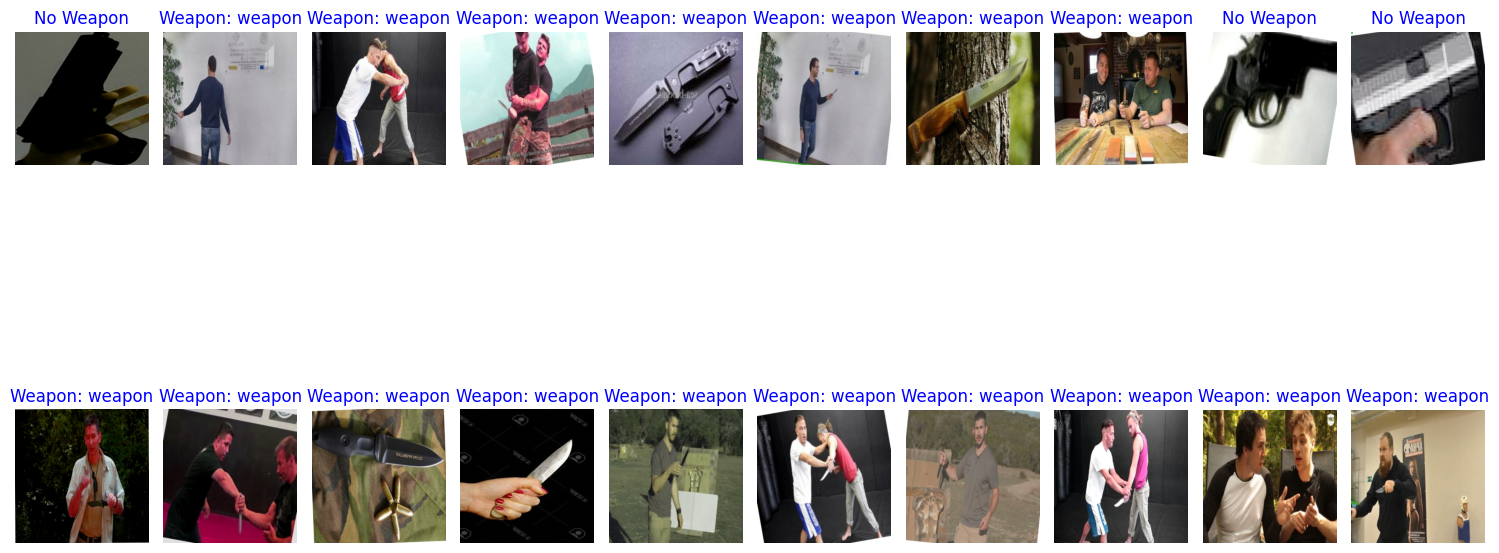

In [15]:

# Function to visualize an image with bounding boxes and labels
def plot_images_with_labels(images, pred_boxes, pred_labels, true_boxes=None, num_cols=3):
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows needed
    
    plt.figure(figsize=(15, num_rows * 5))
    
    for i in range(num_images):
        image = images[i]
        pred_box = pred_boxes[i]
        pred_label = pred_labels[i]
        true_box = true_boxes[i] if true_boxes else None
        
        ax = plt.subplot(num_rows, num_cols, i + 1)
        ax.imshow(image)
        
        # Predicted bounding box
        ax.add_patch(plt.Rectangle((pred_box[0], pred_box[1]), pred_box[2], pred_box[3],
                                   fill=False, color='red', linewidth=2, label="Predicted"))
        
        # True bounding box, if provided
        if true_box is not None:
            ax.add_patch(plt.Rectangle((true_box[0], true_box[1]), true_box[2], true_box[3],
                                       fill=False, color='green', linewidth=2, label="Ground Truth"))
        
        # Set title to display the predicted label
        label_text = "Weapon: " + pred_label if pred_label != "no weapon" else "No Weapon"
        ax.set_title(label_text, color="blue", fontsize=12)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Loop through the test dataset and collect images, predicted boxes, and labels
images, pred_boxes, pred_labels, true_boxes = [], [], [], []
num_images = 20  # Number of images to display

for i, batch in enumerate(test_dataset.take(num_images)):
    image = batch[0][0].numpy()
    true_box = batch[1]['bbox_output'][0].numpy()
    
    # Get predictions
    class_pred, bbox_pred = model.predict(image[np.newaxis, ...])
    pred_class = class_pred.argmax(axis=1)[0]
    pred_label = "weapon" if pred_class > 0.4 else "no weapon"
    
    # Collect for display
    images.append(image)
    pred_boxes.append(bbox_pred[0])
    pred_labels.append(pred_label)
    true_boxes.append(true_box)
    
    if i >= num_images - 1:
        break

# Plot all images in a row with labels
plot_images_with_labels(images, pred_boxes, pred_labels, true_boxes, num_cols=10)



Image 1: -0_jpg.rf.eecfb0dca2432f9d688bfcd064b9559b.jpg
Prediction: knife
Gun probability: 0.00%
Knife probability: 100.00%
Bounding Box: [0.039535682648420334, 0.03481297567486763, 0.946507453918457, 0.8897786140441895]
--------------------------------------------------

Image 2: 0-66-500x500_jpg.rf.ea784198b65e9fecf6dc2d31e6ff44d2.jpg
Prediction: gun
Gun probability: 99.70%
Knife probability: 0.30%
Bounding Box: [0.014709105715155602, 0.020580248907208443, 0.9735692739486694, 0.9706996083259583]
--------------------------------------------------

Image 3: 001_0017_jpg.rf.ae278cb8e0cd2a71224bfbddd69a5377.jpg
Prediction: gun
Gun probability: 99.21%
Knife probability: 0.79%
Bounding Box: [0.05695054307579994, 0.07571359723806381, 0.9067749977111816, 0.8895272612571716]
--------------------------------------------------

Image 4: 001_0065_jpg.rf.9c87d678e07396083a293f54199d8e3e.jpg
Prediction: gun
Gun probability: 99.31%
Knife probability: 0.69%
Bounding Box: [0.391448050737381, 0.29254

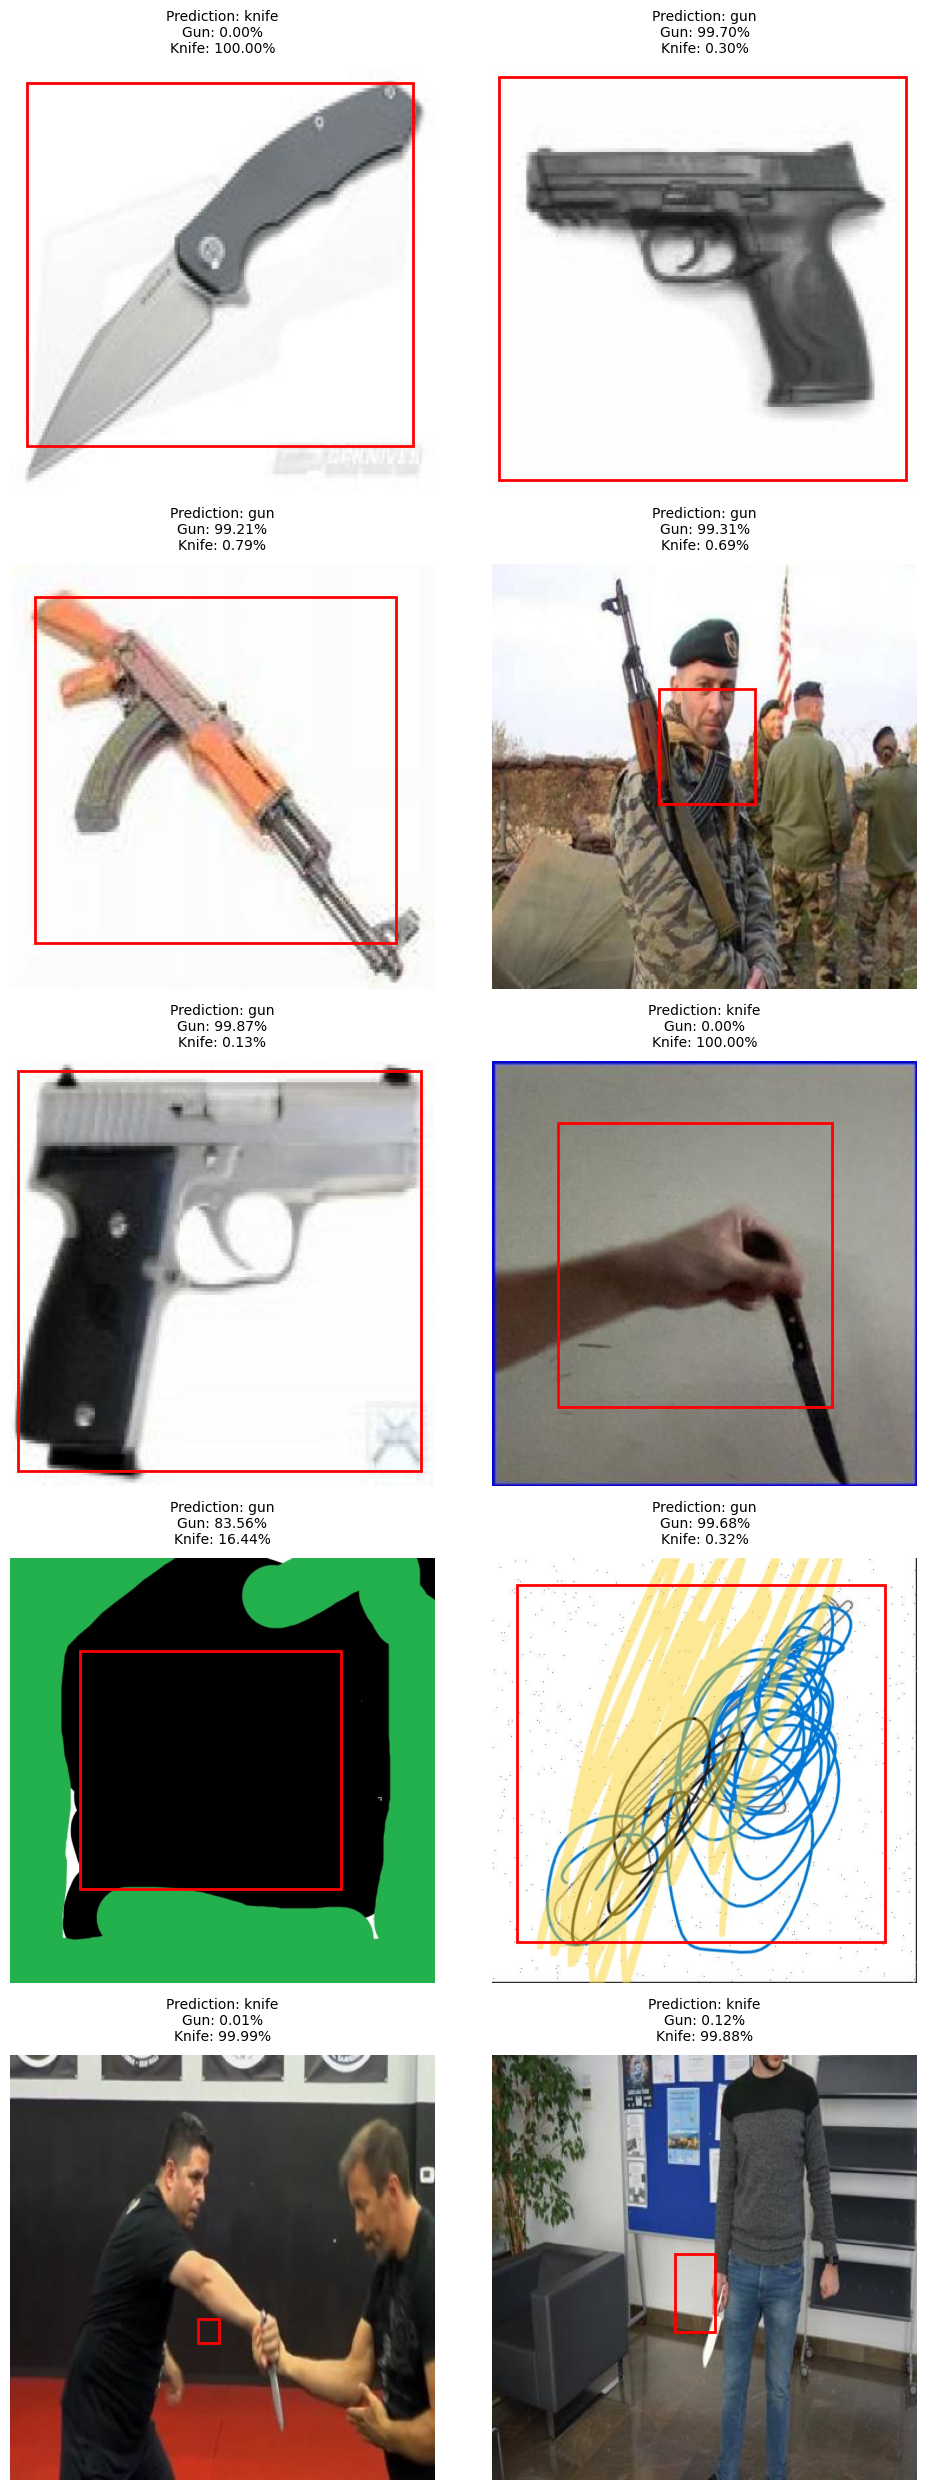

In [20]:
from tensorflow.keras.preprocessing import image as keras_image

def preprocess_image(img_path, model):
    img = keras_image.load_img(img_path, target_size=model.input_shape[1:3])
    img_array = keras_image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def plot_image_with_boxes(ax, img_array, boxes, prediction_label):
    ax.imshow(img_array)
    img_height, img_width = img_array.shape[:2]
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        if xmin < 1 and ymin < 1 and xmax < 1 and ymax < 1:
            xmin, xmax = xmin * img_width, xmax * img_width
            ymin, ymax = ymin * img_height, ymax * img_height
        color = 'red' if prediction_label in ['gun', 'knife'] else 'green'
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 edgecolor=color, linewidth=2, fill=False))
    ax.axis('off')

def test_model_on_folder(folder_path, model, num_images=4, threshold=0.4):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    
    # Calculate number of rows needed (2 images per row)
    num_rows = (min(num_images, len(image_files)) + 1) // 2
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5*num_rows))
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Process each image
    for i, img_file in enumerate(image_files[:num_images]):
        if i >= num_images:
            break
            
        row = i // 2
        col = i % 2
        
        img_path = os.path.join(folder_path, img_file)
        img_array = preprocess_image(img_path, model)
        
        # Get predictions
        predictions = model.predict(img_array, verbose=0)  # Reduced verbosity
        pred_classes = predictions[0][0]
        pred_boxes = predictions[1][0]
        
        # Get the class with highest probability and its value
        max_prob = max(pred_classes)
        class_idx = np.argmax(pred_classes)
        
        # Apply threshold and determine class
        if max_prob > threshold:
            prediction_label = 'gun' if class_idx == 0 else 'knife'
        else:
            prediction_label = 'no weapon'
        
        # Display image with predicted boxes
        img = keras_image.load_img(img_path)
        plot_image_with_boxes(axes[row, col], np.array(img), [pred_boxes], prediction_label)
        
        # Create detailed prediction string
        prediction_str = (f"Prediction: {prediction_label}\n"
                         f"Gun: {pred_classes[0]:.2%}\n"
                         f"Knife: {pred_classes[1]:.2%}")
        
        axes[row, col].set_title(prediction_str, fontsize=10, pad=10)
        
        # Print detailed results
        print(f"\nImage {i+1}: {img_file}")
        print(f"Prediction: {prediction_label}")
        print(f"Gun probability: {pred_classes[0]:.2%}")
        print(f"Knife probability: {pred_classes[1]:.2%}")
        print(f"Bounding Box: {pred_boxes.tolist()}")
        print("-" * 50)
    
    # Hide empty subplots if odd number of images
    if num_images % 2 != 0:
        axes[num_rows-1, 1].axis('off')
        
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Test the model on images in a folder
folder_path = 'try/'  # Specify the path to your folder
test_model_on_folder(folder_path, model, num_images=10, threshold=0.5)

1/1 [==============================] - 0s 287ms/step


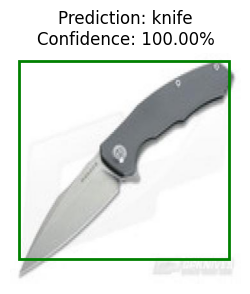

Image: -0_jpg.rf.eecfb0dca2432f9d688bfcd064b9559b.jpg
Prediction: knife
Confidence: 100.00%
Bounding Box: [0.039535682648420334, 0.03481297567486763, 0.946507453918457, 0.8897786140441895]
--------------------------------------------------
1/1 [==============================] - 0s 278ms/step


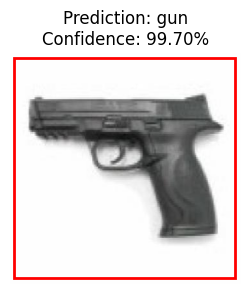

Image: 0-66-500x500_jpg.rf.ea784198b65e9fecf6dc2d31e6ff44d2.jpg
Prediction: gun
Confidence: 99.70%
Bounding Box: [0.014709105715155602, 0.020580248907208443, 0.9735692739486694, 0.9706996083259583]
--------------------------------------------------
1/1 [==============================] - 0s 299ms/step


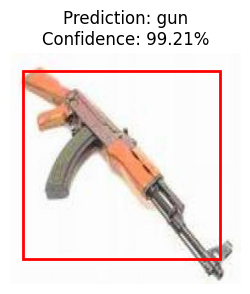

Image: 001_0017_jpg.rf.ae278cb8e0cd2a71224bfbddd69a5377.jpg
Prediction: gun
Confidence: 99.21%
Bounding Box: [0.05695054307579994, 0.07571359723806381, 0.9067749977111816, 0.8895272612571716]
--------------------------------------------------
1/1 [==============================] - 0s 261ms/step


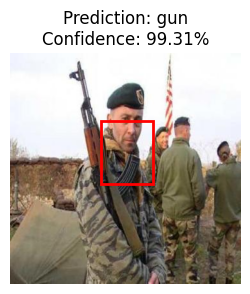

Image: 001_0065_jpg.rf.9c87d678e07396083a293f54199d8e3e.jpg
Prediction: gun
Confidence: 99.31%
Bounding Box: [0.391448050737381, 0.29254886507987976, 0.6181483268737793, 0.5639827847480774]
--------------------------------------------------
1/1 [==============================] - 0s 238ms/step


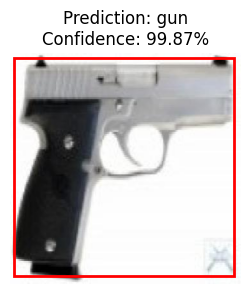

Image: 120px-KahrK9Standard_jpg.rf.b2773568c0b516b0cb2c9df63b7e6b06.jpg
Prediction: gun
Confidence: 99.87%
Bounding Box: [0.016995234414935112, 0.020479511469602585, 0.9666504263877869, 0.9643194079399109]
--------------------------------------------------
1/1 [==============================] - 0s 253ms/step


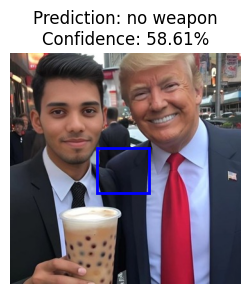

Image: 1730985121098(1).jpg
Prediction: no weapon
Confidence: 58.61%
Bounding Box: [0.3751196563243866, 0.41083189845085144, 0.6015582084655762, 0.6032121777534485]
--------------------------------------------------
1/1 [==============================] - 0s 261ms/step


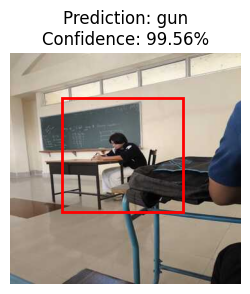

Image: 1730987142650.jpg
Prediction: gun
Confidence: 99.56%
Bounding Box: [0.22467771172523499, 0.19404108822345734, 0.7493988275527954, 0.6860470175743103]
--------------------------------------------------
1/1 [==============================] - 0s 276ms/step


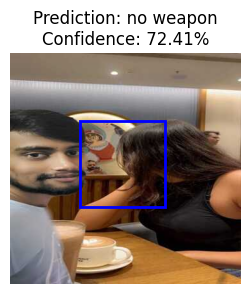

Image: 1730987142662.jpg
Prediction: no weapon
Confidence: 72.41%
Bounding Box: [0.30292680859565735, 0.29109930992126465, 0.6709148287773132, 0.6635207533836365]
--------------------------------------------------
1/1 [==============================] - 0s 246ms/step


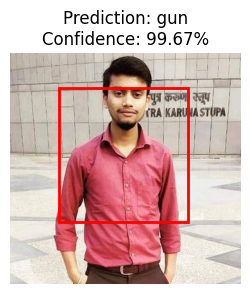

Image: 1730987353504.jpg
Prediction: gun
Confidence: 99.67%
Bounding Box: [0.21056415140628815, 0.152149960398674, 0.767839789390564, 0.7286564707756042]
--------------------------------------------------
1/1 [==============================] - 0s 263ms/step


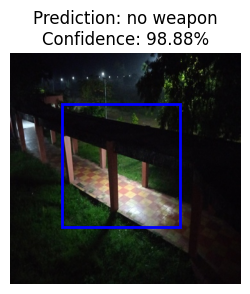

Image: 1730987353522.jpg
Prediction: no weapon
Confidence: 98.88%
Bounding Box: [0.22261479496955872, 0.2177801877260208, 0.7333239316940308, 0.7497040629386902]
--------------------------------------------------
1/1 [==============================] - 0s 255ms/step


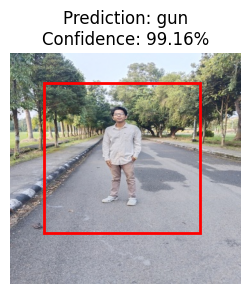

Image: 1730987353540.jpg
Prediction: gun
Confidence: 99.16%
Bounding Box: [0.14569930732250214, 0.12751176953315735, 0.8217991590499878, 0.7781158089637756]
--------------------------------------------------
1/1 [==============================] - 0s 252ms/step


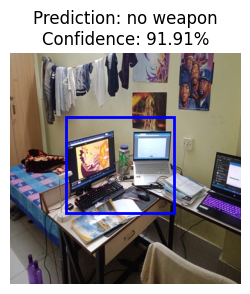

Image: 1730987669985.jpg
Prediction: no weapon
Confidence: 91.91%
Bounding Box: [0.2419687807559967, 0.2747465968132019, 0.7096196413040161, 0.6921131610870361]
--------------------------------------------------
1/1 [==============================] - 0s 276ms/step


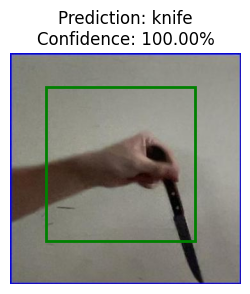

Image: 61_jpg.rf.faa2df06309d10afdf320241d67384c7.jpg
Prediction: knife
Confidence: 100.00%
Bounding Box: [0.15332162380218506, 0.1446620374917984, 0.7976423501968384, 0.8118530511856079]
--------------------------------------------------
1/1 [==============================] - 0s 260ms/step


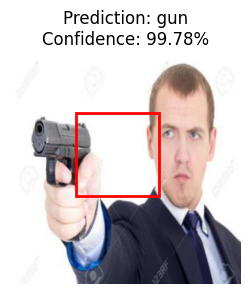

Image: armas--118--jpg_jpg.rf.b7df67d80a84ac31e941734551208b6c.jpg
Prediction: gun
Confidence: 99.78%
Bounding Box: [0.2830665111541748, 0.25634029507637024, 0.6446784138679504, 0.6171852946281433]
--------------------------------------------------
1/1 [==============================] - 0s 247ms/step


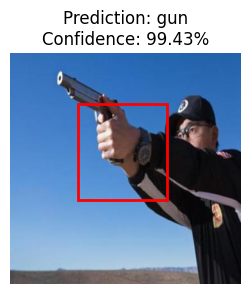

Image: armas--365--jpg_jpg.rf.c7bead4f6295d3e0119e0091b50087a5.jpg
Prediction: gun
Confidence: 99.43%
Bounding Box: [0.2909155786037445, 0.21883618831634521, 0.6801524758338928, 0.6352013349533081]
--------------------------------------------------
1/1 [==============================] - 0s 251ms/step


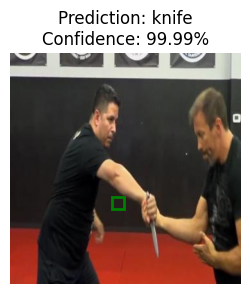

Image: DefenseKnifeAttack1290_jpg.rf.61ba65349e73da18abe601ba2e4a3aa4.jpg
Prediction: knife
Confidence: 99.99%
Bounding Box: [0.4908256530761719, 0.620639979839325, 0.440312922000885, 0.6748655438423157]
--------------------------------------------------
1/1 [==============================] - 0s 248ms/step


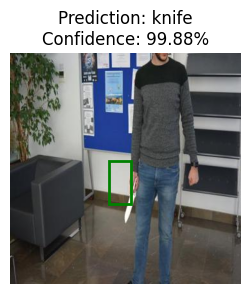

Image: DSC_0046_JPG.rf.2259c5ff82bf9f0f450083537935a665.jpg
Prediction: knife
Confidence: 99.88%
Bounding Box: [0.4285566806793213, 0.46749407052993774, 0.5227763056755066, 0.650216817855835]
--------------------------------------------------
1/1 [==============================] - 0s 253ms/step


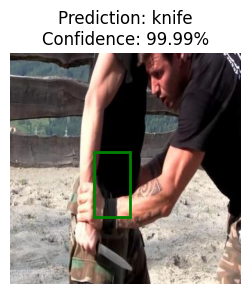

Image: KravMagaTraining21322_jpg.rf.a07d049f9ea6a9cefb575b65c98e06f1.jpg
Prediction: knife
Confidence: 99.99%
Bounding Box: [0.36085113883018494, 0.42876967787742615, 0.5198447704315186, 0.7067952752113342]
--------------------------------------------------
1/1 [==============================] - 0s 249ms/step


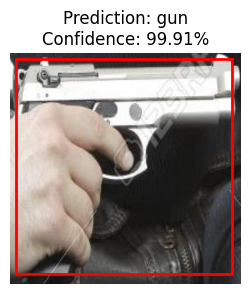

Image: pistol_9039_box1_jpg.rf.abb775859924c57d7a8c4caacf309e01.jpg
Prediction: gun
Confidence: 99.91%
Bounding Box: [0.023907950147986412, 0.025372808799147606, 0.9593552350997925, 0.9539262056350708]
--------------------------------------------------


In [44]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image
import tensorflow as tf
import matplotlib.pyplot as plt

def preprocess_image(img_path, model):
    img = keras_image.load_img(img_path, target_size=model.input_shape[1:3])
    img_array = keras_image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

def plot_image_with_boxes(img_array, boxes, prediction_label):
    plt.imshow(img_array)
    img_height, img_width = img_array.shape[:2]
    for box, label in zip(boxes, prediction_label):
        # Check if box values are normalized, and scale them if necessary
        xmin, ymin, xmax, ymax = box
        if xmin < 1 and ymin < 1 and xmax < 1 and ymax < 1:  # Assume normalized if values < 1
            xmin, xmax = xmin * img_width, xmax * img_width
            ymin, ymax = ymin * img_height, ymax * img_height
        # Plot bounding box with color based on prediction
        color = 'red' if label == "gun" else 'green' if label == "knife" else 'blue'
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                         edgecolor=color, linewidth=2, fill=False))
    plt.axis('off')

def test_model_on_folder(folder_path, model, num_images=5, threshold=0.4):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    for i, img_file in enumerate(image_files[:num_images]):
        img_path = os.path.join(folder_path, img_file)
        img_array = preprocess_image(img_path, model)
       
        # Get predictions
        predictions = model.predict(img_array)
        pred_classes = predictions[0][0]  # Assuming multi-class classification (gun, knife, no weapon)
        pred_boxes = predictions[1][0]    # Assuming bbox_output is the second in the list
       
        # Apply threshold for classification
        confidence = 0
        prediction_label = []
        for j, pred_class in enumerate(pred_classes):
            if pred_class > threshold:
                if j == 0:
                    prediction_label.append("gun")
                elif j == 1:
                    prediction_label.append("knife")
        
        if prediction_label:
            confidence = max(pred_classes)
        if not prediction_label:
            prediction_label.append("no weapon")
            confidence =1- max(pred_classes)
            
        # Display image with predicted boxes
        img = keras_image.load_img(img_path)
        plt.figure(figsize=(3, 3))
        plot_image_with_boxes(np.array(img), [pred_boxes], prediction_label)
       
        # Add title with prediction and confidence
        confidence = max(pred_classes)

        plt.title(f"Prediction: {', '.join(prediction_label)}\nConfidence: {confidence:.2%}")
        plt.show()
       
        # Print detailed results
        print(f"Image: {img_file}")
        print(f"Prediction: {', '.join(prediction_label)}")
        print(f"Confidence: {confidence:.2%}")
        print(f"Bounding Box: {pred_boxes.tolist()}")
        print("-" * 50)
       
        if i >= num_images - 1:
            break

# Test the model on images in a folder
folder_path = 'try/'  # Specify the path to your folder
test_model_on_folder(folder_path, model, num_images=19, threshold=0.99)

In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image as keras_image
import tensorflow as tf
from IPython.display import HTML, display

# Load your pre-trained model
model = load_model('path/to/your/model.h5')

def preprocess_image(img_array):
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

def detect_weapons(frame):
    img_array = preprocess_image(frame)
    predictions = model.predict(img_array)
    pred_classes = predictions[0][0]
    pred_boxes = predictions[1][0]

    prediction_label = []
    for j, pred_class in enumerate(pred_classes):
        if pred_class > 0.4:
            if j == 0:
                prediction_label.append("gun")
            elif j == 1:
                prediction_label.append("knife")
    if not prediction_label:
        prediction_label.append("no weapon")

    confidence = max(pred_classes)

    for box, label in zip(pred_boxes, prediction_label):
        xmin, ymin, xmax, ymax = box
        if xmin < 1 and ymin < 1 and xmax < 1 and ymax < 1:  # Assume normalized if values < 1
            xmin, xmax = xmin * frame.shape[1], xmax * frame.shape[1]
            ymin, ymax = ymin * frame.shape[0], ymax * frame.shape[0]
        color = (0, 255, 0) if label == "no weapon" else (0, 0, 255)
        cv2.rectangle(frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 2)

    return frame, prediction_label, confidence

def display_video():
    cap = cv2.VideoCapture(0)  # Replace with the path to your video file if using a video
    while True:
        success, frame = cap.read()
        if not success:
            break
        frame, prediction_label, confidence = detect_weapons(frame)
        _, buffer = cv2.imencode('.jpg', frame)
        frame = buffer.tobytes()
        display(HTML(f"""
            <div>
                <img src="data:image/jpeg;base64,{base64.b64encode(frame).decode('utf-8')}" width="640" height="480">
            </div>
            <p>Prediction: {', '.join(prediction_label)}</p>
            <p>Confidence: {confidence:.2%}</p>
        """))

display_video()